# ProvedArea.py Demo
---


## Before you begin

If this is your first time using the ProvedArea.py package, you'll likely need to install a couple of additional supporting Python packages (ex: Geopandas, Alphashape, etc). Please refer to the README.md file for more information on package dependencies. 

## Proved Area: Single Realization

To begin, we first instantiate a `ProvedArea()` object with the `realizations` parameter set to `1` and the `phase` parameter set to `"oil"`. Additionally, we need to supply the file paths for the required well header and forecast parameter data sets. Mock example files have been provided in the GitHub repository as `ComboCurve Forecast Parameter Example.csv` and `ComboCurve Header Example.csv`.

Once the `ProvedArea()` object has been instantiated, we can then call the `run_simulation()` method to execute the main driver function of the object. After all realizations have completed, we can then utilize the various package methods to visualize the results and export ShapeFiles. 

In [15]:
from ProvedArea import ProvedArea

headers = 'ComboCurve Header Example.csv'
forecast_parameters = 'ComboCurve Forecast Parameter Example.csv'

single_realization = ProvedArea(realizations = 1, phase = 'oil', header_path = headers, forecast_parameters_path = forecast_parameters)
single_realization.run_simulation()

Generating realizations...
Realization Number: 1

All realizations completed successfully.
Proved Radii Distance: 8.442602535937503 miles


### Review realization outputs

Using the `plot_comparisons()` method we can review underlying logic behind our realization's proved radii selection. 

The left chart shows the Average EUR/PLL of the various well groupings and is used to determine what radii level is considered proved. The chart on the right shows the corresponding well count for each of the well groupings.

According to SPEE Monograph 3, the <i>proved</i> radii group is that which preceeds either the radii group whose Average EUR/PLL dips below 90% of the analog well set's Average EUR/PLL or the radii group that dips below a well count of 50. 

Proved radii level: r5.


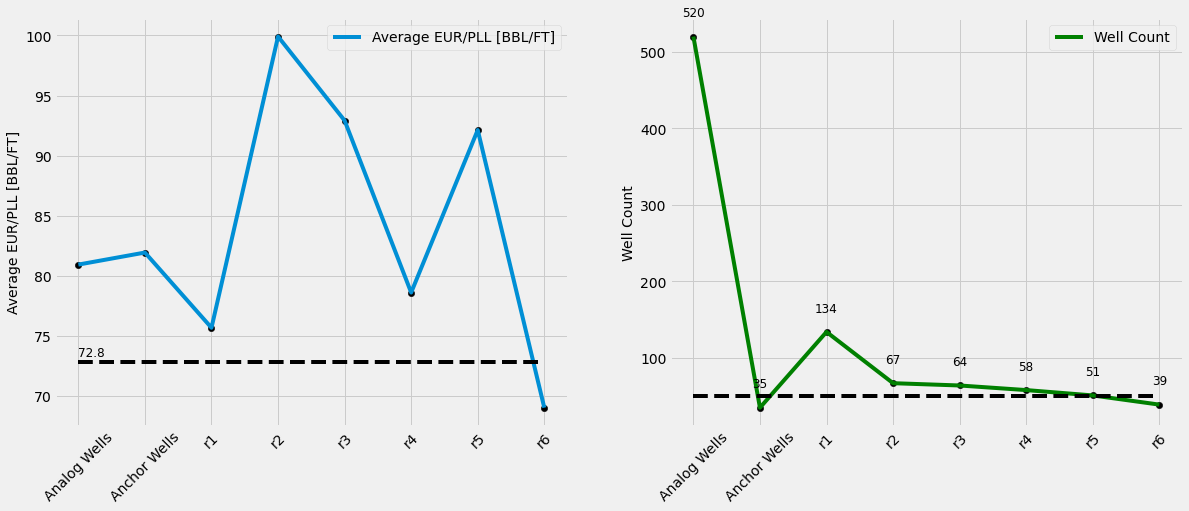

In [16]:
single_realization.plot_comparisons() 
print(f"Proved radii level: r{single_realization.proved_radii}.")

### Visualize Analog and Anchor Wells

Using the `plot_wells()` method we can quickly visualize and identify both the analog and anchor wells in addition to the wells that fall into the various raddi layers. As defined in the legend, the wells shown in black are the analog wells, while the anchor wells are the center points of the expanding grey concentric radii. The wells that lie within the concentric expanding radii are color-coded according to which layer they fall into. 

Note: Currently, ProvedArea.py uses a well's surface hole coordinates to define its location.

/Users/travissalomaki/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/Users/travissalomaki/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/Users/travissalomaki/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/Users/travissalomaki/anaconda3/lib/python3.7/site-packages/geopandas/plo

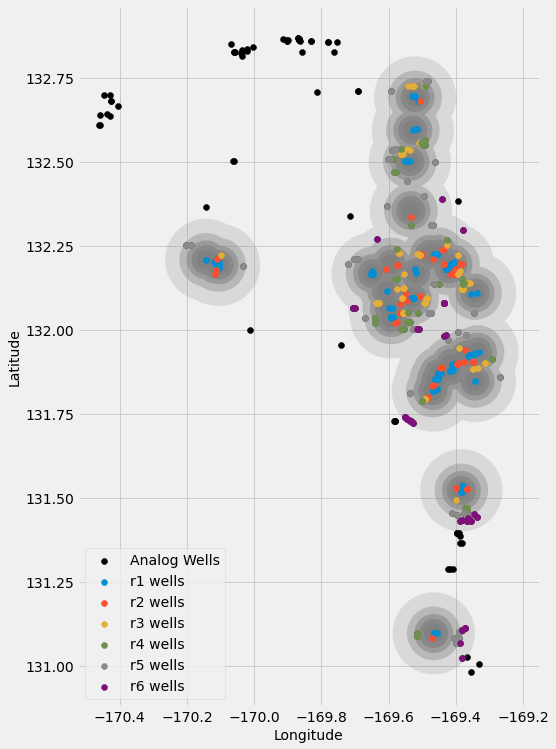

In [17]:
single_realization.plot_wells()

### Define the Proved Radii and Proved Area

Using the `plot_proved_areas()` method, we can visualize the proved radii bubbles along with the final proved area boundary. The proved area geometries represent the portions of the resource play that can be considered "statistically proven" as calculated by our realization. 

Note, this boundary does not represent the <i>entire</i> proved area, just the <i>statistically</i> proved area. Additionally, due to the random nature of how the anchor points are selected, the proved area shown below is non-unique and is highly dependant upon which points were randomly selected are our original anchor well set. Lastly, the underlying assumption is that the wells shown below represent a contiguous drilling area. Further additions to the program will attempt to treat separate drilling areas individually and compare the results. 

/Users/travissalomaki/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


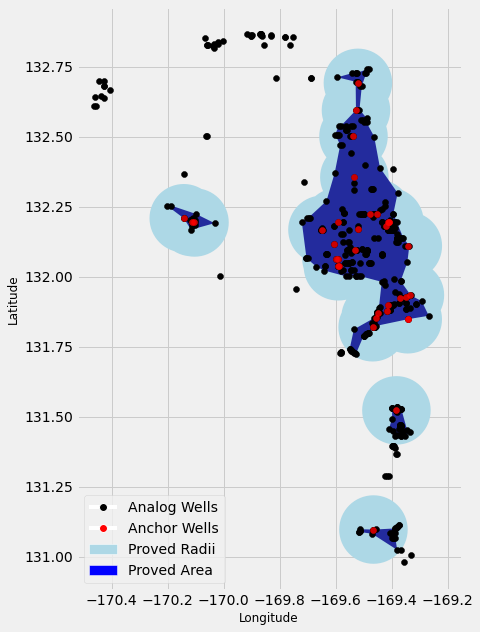

In [18]:
single_realization.plot_proved_areas()

## Proved Area: Multiple Realizations

Here, we once again instantiate a `ProvedArea` object, however, this time we set the `realizations` parameter equal to `500`. Doing this allows us to generate a unique probabilistic solution to the proved area boundary using the aggregation of multiple realizations in a Monte-Carlo inspired approach. 

Currently, the program is not set-up to generate the realizations in parallel and will thus take a few minutes to complete depending on the processing power of your computer. 

Note, certain realizations will be omitted from the final result as the selected anchor points were not representative of the analog well set distribution. 

In [19]:
multiple_realizations = ProvedArea(500, headers, forecast_parameters, 'oil')
multiple_realizations.run_simulation()

Generating realizations...
Realization Number: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 2

### Stack and aggregate realizations

With multiple realizations to play with, we can now use the `plot_aggregate_realization()` method to visualize the aggregated results. First, however, it's important to understand what this function is doing under the hood. 

Technically speaking, every realization generated is considerd statistically "proven" as defined by the SPEE Monograph 3 workflow. That being said, since the realizations vary highly with anchor well selection, some proven areas will be more optimistic and wide ranging, while others will be more conservative and smaller in domain. Therefore, in order to combat the variability of our outputs, we must perform a method of aggregation to ultimately yield some sort of reproducible answer. Although the proved area domain may vary largely from realization to realization, certain 'pieces' of the proved area may show up more often than others. This idea is essentially how the aggregation routine works. For all proved area realizations, imagine we took each ouput and stacked it vertically on top of one another. From there, we can count the number of overlapping 'pieces' between the various realization layers and make the assumption that pieces with higher overlaps can more confidently be considered part of the true proven area. A simplified example of this idea is shown below. 

In the output of the `plot_aggregate_realization()` function, you can see that the shape is broken up into various pieces with lighter areas representing sections of greater overlap and darker areas representing sections of lesser overlap. 

In order to end up with a final 'proved' boundary or perimeter, we can set a threshold for the number of required overlapping sections. In practice, this is accomplished by choosing a overlap percentile where the smaller the percentile, the larger the number of required overlaps and vice versa. Therefore, if you plotted the 90th percentile (P90), you'd get a rather large final boundary with a low minimum overlap count, whereas if you plotted the 10th percentile (P10), you'd get a smaller boundary containing only the pieces that had a high amount of overlaps. Ultimately, it is up to the engineer to decide which percentile is most representative of their resource play. 

Feel free to adjust the percentile inputs in the example functions below. 

![Overlap Diagram](Overlaps.png)

/Users/travissalomaki/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


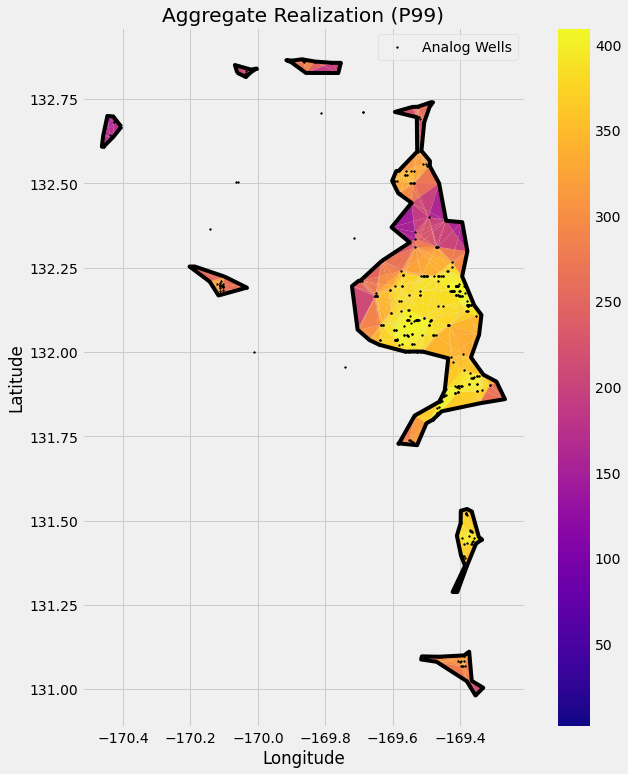

In [20]:
multiple_realizations.plot_aggregate_realization(0.99)

/Users/travissalomaki/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


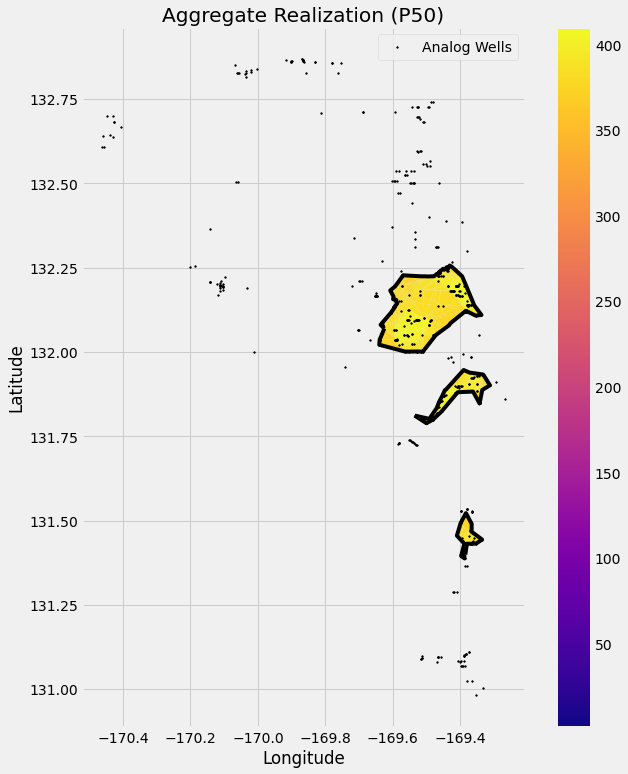

In [21]:
multiple_realizations.plot_aggregate_realization(0.5)

### Export results as a ShapeFile

Once you've decided which percentile you'd like to proceed with, you can export the boundary of the proved area as a ShapeFile that can be uploaded back into ComboCurve, Prism, SpotFire, or any platform that supports ShapeFiles.

The `export_shapefile()` method will create a file containing the requisite components of a working ShapeFile. From here, simply zip/compress the output file, navigate to the Map Settings page of ComboCurve and upload it accordingly. 

In [14]:
multiple_realizations.export_shapefiles(0.9)